In [2]:
from typing import Any
from torch.utils.data import Dataset
import numpy as np

import cv2
import glob
from tqdm import tqdm 
import pandas as pd 
import os, sys
from PIL import Image

import numpy as np
parent_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add the parent directory to the Python path
sys.path.append(parent_dir)
print(sys.path)
from tools import BreaKHis
from torchvision import transforms
from PIL import Image
import torch 
import matplotlib.pyplot as plt

['c:\\Users\\user\\Dersler\\Machine and Deep Learning\\Project\\breast_histopathology_clf\\notebooks', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\python38.zip', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\DLLs', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\lib', 'c:\\Users\\user\\anaconda3\\envs\\breakkit', '', 'C:\\Users\\user\\AppData\\Roaming\\Python\\Python38\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\lib\\site-packages', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\lib\\site-packages\\win32', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\lib\\site-packages\\win32\\lib', 'c:\\Users\\user\\anaconda3\\envs\\breakkit\\lib\\site-packages\\Pythonwin', 'c:\\Users\\user\\Dersler\\Machine and Deep Learning\\Project\\breast_histopathology_clf']


In [12]:
myDataset = BreaKHis(root='C:\\Users\\user\\Dersler\\Machine and Deep Learning\\Project\\BreaKHis_v1\\',
                transform=transforms.Compose([
                        transforms.ToTensor(),
                    ]),
                    mf= '400X'
)

100%|██████████| 1232/1232 [00:13<00:00, 94.29it/s]


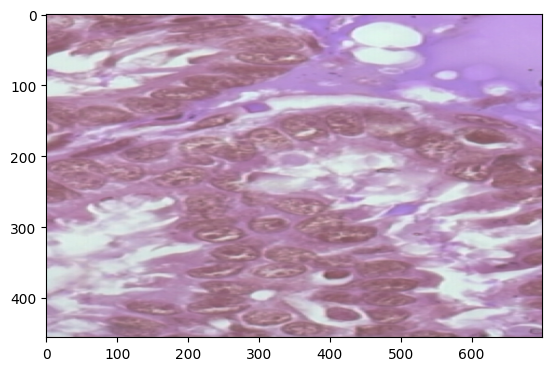

In [13]:
img = myDataset[0][0]
img = torch.transpose(img, 0, -1)
plt.imshow(img)

In [14]:
channel_std = np.std(myDataset.images, axis=(0, 1,2))
print(channel_std)

[29.4867471  51.11873185 36.35026414]


In [4]:
# Calculate the mean pixel value of each channel
print(myDataset.images.shape)
channel_means = np.mean(myDataset.images, axis=(0, 1,2))
print(channel_means)

(1995, 700, 456, 3)
[196.90156367 166.25184329 204.76493343]


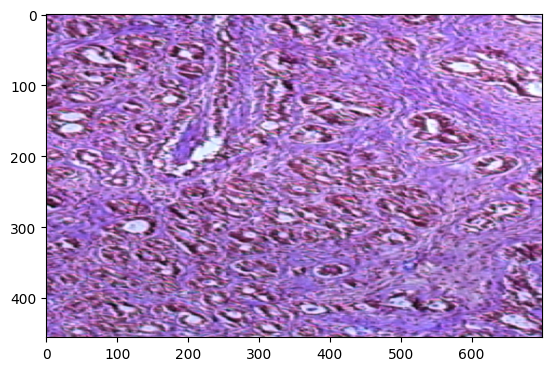

In [47]:
def scale_decimal(image):
    image = np.array(image)
    # Scale the image between 0 and 255 for each channel
    scaled_image = np.zeros_like(image, dtype=np.float32)
    for c in range(image.shape[2]):
        channel = image[..., c]
        scaled_channel = (channel - np.min(channel)) * (1 / (np.max(channel) - np.min(channel)))
        scaled_image[..., c] = scaled_channel
    return scaled_image

img = myDataset[39][0]
img = torch.transpose(img, 0, -1)
scaled = scale_decimal(img - channel_means)
plt.imshow(scaled)

c:\Users\user\anaconda3\envs\breakkit\lib\site-packages\skimage\color\colorconv.py:1695: RuntimeWarning: overflow encountered in exp
  rgb = np.exp(log_rgb)
C:\Users\user\AppData\Local\Temp\ipykernel_19560\3867705419.py:61: RuntimeWarning: invalid value encountered in divide
  scaled_image = (image - np.min(image, axis=0)) / (np.max(image, axis=0) - np.min(image, axis=0))  # Scale to [0, 1]


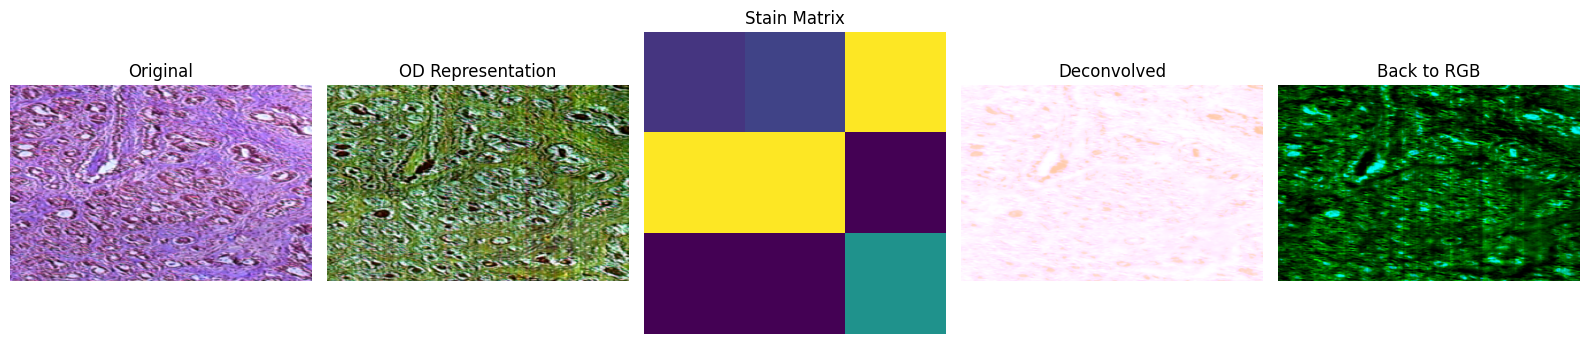

[24.5        27.84168174 24.5        ... 24.5        29.88142797
 24.5       ] [[1208.71630859 1213.31323242 1210.43322754]
 [   2.98902941    4.6624279     2.87450528]
 [   2.77035737    4.31406927    2.74295139]]


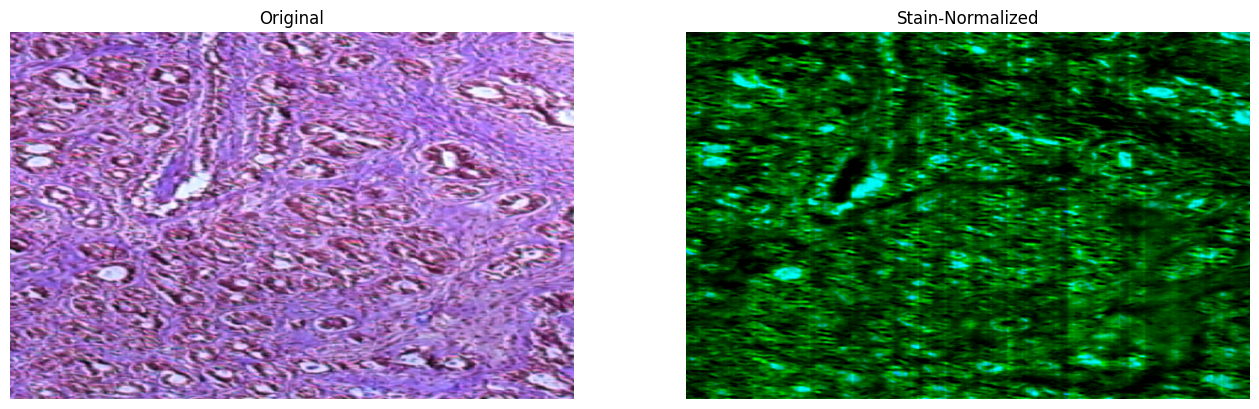

In [48]:
import numpy as np
from scipy.linalg import svd, pinv
from skimage.color import separate_stains, combine_stains
from skimage.exposure import rescale_intensity

def stain_normalization(image, threshold_beta=0.4, num_singular_values = 3, robust_extreme_percentile=75):
    # Step 1: Convert image to optical density (OD)
    od_image = convert_to_od(image)
    
    # Step 2: Remove transparent pixels and low-intensity data
    # filtered_image = remove_transparent_pixels(od_image, threshold_beta=threshold_beta)
    
    # Step 3: Perform Singular Value Decomposition (SVD) and Create plane 
    # stain_matrix = create_stain_matrix(od_image)
    
    # # Step 3 & 4: Project OD values
    projected_image = project_onto_plane(od_image, num_singular_values=num_singular_values)
    
    # # Step 5: Calculate angles of each point
    # angles = calculate_angles(projected_image)
    
    # # Step 6: Determine stain concentrations
    # extreme_angles, alpha_percentile, beta_percentile = determine_stain_concentrations(angles, robust_extreme_percentile=robust_extreme_percentile)
    
    # # Step 7: Convert extreme values back to OD space
    # extreme_values_rgb = convert_extreme_values(extreme_angles)
    # Step 8: Deconvolve the image using stain vectors
    deconvolved_image = color_deconvolution(od_image, projected_image)
    
    # Assuming you have the output images from each step stored in variables: output_1, output_2, ..., output_8
    back_to_rgb = inverse_convert_to_od(deconvolved_image)
    # Create a figure with 2 rows and 4 columns of subplots
    fig, axes = plt.subplots(1,5 , figsize=(16, 8))

    # Flatten the axes array to simplify indexing
    axes = axes.flatten()

    # Plot the images in each subplot
    titles = ['Original', 'OD Representation','Stain Matrix', 'Deconvolved', 'Back to RGB']
    # outputs = [image, od_image, filtered_image, stain_matrix, projected_image, angles, extreme_angles, extreme_values_rgb, deconvolved_image]
    outputs = [image, od_image, projected_image, deconvolved_image, back_to_rgb ]
    
    for i, ax in enumerate(axes):
        ax.imshow(scale_decimal(outputs[i]))
        ax.set_title(titles[i])
        ax.axis('off')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

    return back_to_rgb, stain_matrix

def scale_decimal(image):
    # Perform scaling or normalization to bring the pixel values within the [0, 255] range
    if np.max(image) == 1:
        return image
    
    scaled_image = (image - np.min(image, axis=0)) / (np.max(image, axis=0) - np.min(image, axis=0))  # Scale to [0, 1]
    scaled_image = (scaled_image * 255).astype(np.uint8)  # Scale to [0, 255] and convert to uint8 data type
    return scaled_image

def convert_to_od(image):
    # Convert RGB image to Optical Density (OD) representation
    # Args:
    #     image: RGB image as a numpy array (height x width x channels)
    # Returns:
    #     od_image: Optical Density representation of the input image
    
    # Ensure image is in floating-point format for accurate computations
    image = image.astype(np.float32)
    
    # Apply negative logarithm to RGB channels
    od_image = -np.log10((image + 1) / 255.0)
    # od_image = scale_decimal(od_image)

    return od_image

def remove_transparent_pixels(image, threshold_beta=20):
    # Remove transparent pixels and data below the threshold
    # ...

    filtered_image = image.copy()
    filtered_image[np.where(image<threshold_beta)] = 0
    
    return filtered_image

def create_stain_matrix(filtered_image, num_singular_values = 3):
    # Create the stain matrix from SVD results
    # ...

    # Step 3: Perform Singular Value Decomposition (SVD)
    stain_matrix = np.zeros((3, 3))
    for ch in range(3):
        U, s, V = svd(filtered_image[:, :, ch], full_matrices=False, check_finite=False)
        # Step 4: Create plane and project OD values
        stain_matrix[:, ch] = s[:num_singular_values]
        # plt.imshow(scale_decimal(stain_matrix))
    return stain_matrix


def project_onto_plane(od_image, num_singular_values = 3):
    projected_image = np.zeros((num_singular_values, num_singular_values, 3))
    for ch in range(3):
        U, s, V = svd(od_image[:, :, ch], full_matrices=False)
        projected_image[:, :, ch] = U[:num_singular_values].dot(od_image[:, :, ch]).dot(V[:num_singular_values].T)

    projected_image = np.mean(projected_image, axis=-1)
    return projected_image

# def calculate_angles(projected_image):
#     angles = np.arctan2(projected_image[:, :, :], projected_image[:,:, :])
#     return angles

# def determine_stain_concentrations(angles, robust_extreme_percentile=0.75):
#     # Determine robust extremes (α-th and (100-α)-th percentiles)
#     # ...
#     lower_percentile = np.percentile(angles, robust_extreme_percentile)
#     upper_percentile = np.percentile(angles, 100 - robust_extreme_percentile)

#     filtered_arr = angles.copy()
#     filtered_arr[np.where((angles > upper_percentile) & (angles < lower_percentile))] = 0
#     print(lower_percentile, upper_percentile)
#     return filtered_arr, lower_percentile, upper_percentile

# def convert_extreme_values(extreme_angles):
#     # Convert extreme values back to OD space
#     # ...
#     extreme_values_od = np.cos(extreme_angles)
#     extreme_values_rgb = inverse_convert_to_od(extreme_values_od)

#     return extreme_values_rgb

def inverse_convert_to_od(od_image):
    # Inverse function of converting OD image to RGB image
    
    # Convert back to linear scale
    image = 10**(-od_image)
    
    # Scale to the range [0, 255]
    image = (image * 255.0) - 1
    
    return image

# def deconvolve_image(image, extreme_values, num_iterations=35):
#     from skimage.transform import resize
#     from skimage.restoration import richardson_lucy, wiener

#     # Deconvolve the image using the determined stain vectors
#     # ...
#     # Deconvolve the image using the Richardson-Lucy algorithm and the determined stain matrix (extreme_values)
#     deconvolved_image = np.zeros(shape=(extreme_values.shape[0], extreme_values.shape[1], 3))
#     resized_image = resize(image, deconvolved_image.shape)
    
#     for ch in range(3):
#         deconvolved_image[:, :, ch] = richardson_lucy(resized_image[:, :, ch], extreme_values, num_iter=num_iterations)
#         # deconvolved_image[:, :, ch] = resized_image[:, :, ch] / extreme_values
    
#     # print(np.nonzero(deconvolved_image), np.nonzero(resized_image), np.nonzero(extreme_values))

#     deconvolved_image_rgb = inverse_convert_to_od(deconvolved_image)
#     print(np.nonzero(deconvolved_image))
#     return deconvolved_image_rgb

def color_deconvolution(od_image, stain_matrix):
    # Perform color deconvolution using stain matrix
    # Args:
    #     od_image: Optical Density image as a numpy array (height x width x channels)
    #     stain_matrix: Stain matrix as a numpy array (height x width x channels)
    # Returns:
    #     deconvolved_image: Deconvolved image with normalized stain concentrations

    # Separate the stains using the stain matrix
    separated_stains = separate_stains(od_image, stain_matrix)
    # Rescale the intensity of each stain
    for i in range(stain_matrix.shape[-1]):
        separated_stains[:, :, i] = rescale_intensity(separated_stains[:, :, i], out_range=(0, 1))

    # Combine the stains to reconstruct the normalized image
    deconvolved_image = combine_stains(separated_stains, stain_matrix)
    return deconvolved_image


back_to_rgb, stain_matrix = stain_normalization(scaled, num_singular_values = 3)
print(back_to_rgb[np.where(back_to_rgb != 0)], stain_matrix)

fig, axes = plt.subplots(1,2 , figsize=(16, 8))
# Flatten the axes array to simplify indexing
axes = axes.flatten()

# Plot the images in each subplot
titles = ['Original', 'Stain-Normalized']
# outputs = [image, od_image, filtered_image, stain_matrix, projected_image, angles, extreme_angles, extreme_values_rgb, deconvolved_image]
outputs = [scaled, back_to_rgb/255 ]
for i, ax in enumerate(axes):
    ax.imshow(scale_decimal(outputs[i]))
    ax.set_title(titles[i])
    ax.axis('off')